## The Start

In [1]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn.preprocessing import MinMaxScaler    

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
SEED = 777
torch.manual_seed(SEED)
np.random.seed(SEED)

#-------------------------
BATSIZE = 32

In [3]:
print("============================================================================================")
# set device to cpu or cuda
device = torch.device('cpu')
if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")
print("============================================================================================")

Device set to : NVIDIA GeForce RTX 2080 Ti


## Data

In [4]:
#address = 'D:/github/GitHub/DL/시계열/'
df = pd.read_excel('pv_data.xlsx')
df.drop(columns=['solar irradience(invalid)'], inplace=True)

In [5]:
display(df.shape)
display(df.head(3))

(65535, 8)

,time,wind speed,wind direction,ambient temperature,pressure,humidity,solar irradience,PV power output
0,2017-01-01 00:15:00,-0.320896,-0.066011,-0.024088,-0.614618,-0.059871,0.0,0.0
1,2017-01-01 00:30:00,-0.335821,-0.067956,-0.025996,-0.606476,-0.058252,0.0,0.0
2,2017-01-01 00:45:00,-0.350746,-0.069789,-0.027427,-0.598417,-0.055825,0.0,0.0


In [6]:
scaler = MinMaxScaler()

X = df.iloc[:, 1:-1].values
Y = df.iloc[:, -1].values.reshape(-1, 1)

X_scaled = scaler.fit_transform(X)
Y_scaled = scaler.fit_transform(Y)

display(f'X: {X.shape}')
display(f'Y: {Y.shape}')

display(df.head(3))

'X: (65535, 6)'

'Y: (65535, 1)'

,time,wind speed,wind direction,ambient temperature,pressure,humidity,solar irradience,PV power output
0,2017-01-01 00:15:00,-0.320896,-0.066011,-0.024088,-0.614618,-0.059871,0.0,0.0
1,2017-01-01 00:30:00,-0.335821,-0.067956,-0.025996,-0.606476,-0.058252,0.0,0.0
2,2017-01-01 00:45:00,-0.350746,-0.069789,-0.027427,-0.598417,-0.055825,0.0,0.0


## Arrange

In [7]:
# 예측 sequence끼리 겹치게 구성.
'''
def seq_data(x, y, seq_len):

    x_seq = [] # (5, 4)인 데이터를 계속 넣어서 200개 만듦 ---> (200, 5, 4)
    y_seq = []

    # sequence_length = 5이고 데이터 100개로 가정하면 range(95)가 됨. ----> 0~94
    # x[95:95+5]가 되면 x[95:100], y[100]이므로 말이 안 됨(인덱싱은 0~99까지 가능)
    for i in range(len(x)-seq_len): 
        x_seq.append(x[i:i+seq_len]) # x[1:1+5] ---> 1,2,3,4,5 ---> 5개
        y_seq.append(y[i+seq_len]) # y[1+5] ---> 6 ---> 5개로 6번째 값 예측.

    return torch.tensor(x_seq, dtype=torch.float32).to(device), torch.tensor(y_seq, dtype=torch.float32).to(device)
'''
print()

In [8]:
# 예측 sequence끼리 안 겹치게 구성.
def seq_data(x, y, xseq_len, yseq_len):  # N=100, in=5, out=3

    xseqlist = []
    yseqlist = []
    it = (len(x) - xseq_len) // yseq_len # 몫

    for i in range(it):
        xseqlist.append(x[i*yseq_len: i*yseq_len + xseq_len])
        yseqlist.append(y[xseq_len + i*yseq_len: xseq_len + i*yseq_len + yseq_len])
        # e.g.
        # x[0*3: 0*3 + 5]        =x[0:5],     x[1*3: 1*3 + 5]        =x[3:8] 
        # y[5 + 0*3: 5 + 0*3 + 3]=y[5:8],     y[5 + 1*3: 5 + 1*3 + 3]=y[8:11]
        #
        # x[92:97]
        # y[97:100]

    return torch.tensor(xseqlist, dtype=torch.float32).to(device), torch.tensor(yseqlist, dtype=torch.float32).to(device)

# 검증 방법
'''
xseq_len=3, yseq_len=2로 두고 아래처럼 나오면 됨.
tensor([[0.1464, 0.3692, 0.7066, 0.8443, 0.7229, 0.0147],
        [0.1561, 0.3800, 0.7066, 0.8379, 0.7245, 0.0178],
        [0.1638, 0.3901, 0.7073, 0.8305, 0.7261, 0.0249]], device='cuda:0') 여기의 맨 끝 줄이
tensor([[0.1638, 0.3901, 0.7073, 0.8305, 0.7261, 0.0249],                   여기서 맨 첫 줄이 됨.
        [0.1715, 0.4002, 0.7097, 0.8214, 0.7278, 0.0500],
        [0.1792, 0.4102, 0.7134, 0.8107, 0.7290, 0.1010]], device='cuda:0')
tensor([[0.1792, 0.4102, 0.7134, 0.8107, 0.7290, 0.1010],
        [0.1869, 0.4200, 0.7180, 0.7988, 0.7306, 0.1671],
        [0.1927, 0.4295, 0.7235, 0.7861, 0.7318, 0.2053]], device='cuda:0')

tensor([[0.0915],
        [0.2134]], device='cuda:0') 아래 세 개는 서로 안 겹쳐야 정상.
tensor([[0.3266],
        [0.5406]], device='cuda:0')
tensor([[0.4303],
        [0.3093]], device='cuda:0')
'''
print()

In [29]:
xseq_len = 5
yseq_len = 4
X_seq, Y_seq = seq_data(X_scaled, Y_scaled, xseq_len=xseq_len, yseq_len=yseq_len)

split_trvaltest = int(len(X_seq)*0.9)

x_trainval = X_seq[:split_trvaltest]
y_trainval = Y_seq[:split_trvaltest]
x_test = X_seq[split_trvaltest:] # 맨 끝
y_test = Y_seq[split_trvaltest:]

split_trval = int(len(x_trainval)*0.8)

x_train = x_trainval[:split_trval] # 맨 앞
y_train = y_trainval[:split_trval]
x_val = x_trainval[split_trval:] # 중간
y_val = y_trainval[split_trval:]

print('XY: ', X_seq.shape, Y_seq.shape)
print('Train: ', x_train.shape, y_train.shape)
print('Validation: ', x_val.shape, y_val.shape)
print('Test: ', x_test.shape, y_test.shape)

XY:  torch.Size([16382, 5, 6]) torch.Size([16382, 4, 1])
Train:  torch.Size([11794, 5, 6]) torch.Size([11794, 4, 1])
Validation:  torch.Size([2949, 5, 6]) torch.Size([2949, 4, 1])
Test:  torch.Size([1639, 5, 6]) torch.Size([1639, 4, 1])


## Loader

In [10]:
# sequential data라 모든 epoch에서 같은 패턴만 보게 됨.,
# 모델이 시계열의 순서 그 자체를 학습하게 될 우려가 있음. ----> shuffle=True
trainset = TensorDataset(x_train, y_train)
trainloader = DataLoader(trainset, batch_size=BATSIZE, shuffle=True)

# Validation과 Test는 말 그대로 평가의 의미가 있으므로 
# 같은 패턴을 유지해야 비교할 수 있음. ----> shuffle=False
valset = TensorDataset(x_val, y_val)
valloader = DataLoader(valset, batch_size=BATSIZE, shuffle=False)

testset = TensorDataset(x_test, y_test)
testloader = DataLoader(testset, batch_size=BATSIZE, shuffle=False)

In [11]:
for x, y in testloader:
    display(x.shape)
    display(y.shape)
    break

torch.Size([32, 5, 6])

torch.Size([32, 4, 1])

## Model

In [12]:
# out, (hn, cn) = self.lstm
# out: containing the output features (h_t) from the last layer of the LSTM, for each t.
# hn:  containing the final hidden state for each element in the sequence.
# cn:  containing the final cell state for each element in the sequence.
# 출처 - 파이토치 공식 문서

class LSTMModel(nn.Module):
    def __init__(self, input_len, hidden_len, seq_len, num_layers, output_len):
        super(LSTMModel, self).__init__()
        self.input_len = input_len
        self.hidden_len = hidden_len
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.output_len = output_len
        self.lstm = nn.LSTM(self.input_len, self.hidden_len, self.num_layers, batch_first=True, dropout=0.3) # model.eval() 사용 시 Dropout은 자동 해제됨.
        self.linear = nn.Linear(self.hidden_len*self.seq_len, self.output_len)
        self.relu = nn.ReLU()

    def forward(self, x):
        self.lstm.flatten_parameters()
        # x:  (32, 5, 6) ----> feature 6개가 하나로 5일치를 묶음. 32개 배치.
        h0 = torch.zeros((self.num_layers, x.shape[0], self.hidden_len)).to(device) 
        c0 = torch.zeros((self.num_layers, x.shape[0], self.hidden_len)).to(device)
        # h0: (2, 32, 8) ----> hidden 8개를 32개 배치에 대해, two layer로.
        # c0: (2, 32, 8) ----> hidden 8개를 32개 배치에 대해, two layer로.
        out, (hn, cn) = self.lstm(x, (h0,c0)) 
        # out: (32, 5, 8) ----> 각각들이 hidden을 8개씩 출력했고 5일치씩 묶임. 32개 배치.
        out = out.reshape(out.shape[0], -1)
        # out: (32, 40)   ----> 8개씩 5일치인 걸 쭉 펼친 거임.
        out = self.linear(out) 
        # out: (32, 1)    ----> 5일치 보고 6일차를 예측.
        out = self.relu(out)
        # out: (32, 1)

        return out

## Training

In [13]:
model = LSTMModel(input_len=X_seq.shape[2], hidden_len=8, seq_len=5, num_layers=2, output_len=Y_seq.shape[1]).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.RAdam(model.parameters(), lr=1e-3)

In [14]:
loss_graph = []
n = len(trainloader)

for epoch in range(1, 900+1):
    running_loss = 0.0
    
    for x_true, y_true in trainloader:
        # y_true: (32, 4, 1)
        y_pred = model(x_true) 
        # y_pred: (32, 4)
        y_pred = y_pred.unsqueeze(2)
        # y_pred: (32, 4, 1)
        loss = criterion(y_pred, y_true)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss_graph.append(running_loss/n)
    if epoch % 100 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 100] loss: 0.0223
[epoch: 200] loss: 0.0203
[epoch: 300] loss: 0.0193
[epoch: 400] loss: 0.0184
[epoch: 500] loss: 0.0180
[epoch: 600] loss: 0.0179
[epoch: 700] loss: 0.0174
[epoch: 800] loss: 0.0171
[epoch: 900] loss: 0.0173


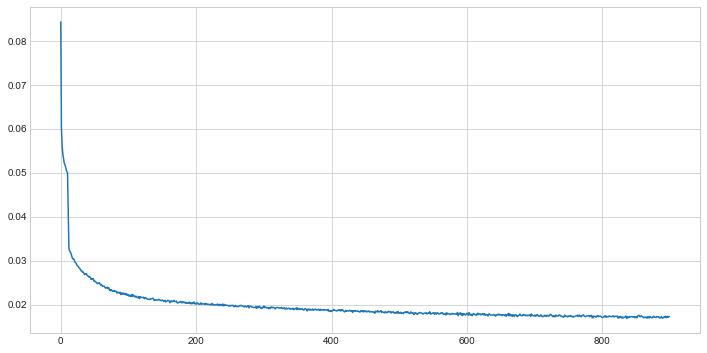

In [15]:
plt.figure(figsize=(12,6))
plt.plot(loss_graph)
plt.show() 

## Test

In [35]:
test_loss_list = []
epoch_loss = 0

predlist = []

model.eval()
with torch.no_grad():
    for x, y_true in testloader:

        y_pred = model(x)
        y_pred = y_pred.unsqueeze(2)
        kane = y_pred.flatten().cpu().tolist()
        predlist += kane

        loss = criterion(y_pred, y_true)

        epoch_loss += loss.item()
    
    test_loss_list.append(epoch_loss/n)

display(test_loss_list)

truelist = y_test.flatten().tolist()

print(f'Y: {Y.shape}')
print('XY_seq: ', X_seq.shape, Y_seq.shape)
print('Train: ', x_train.shape, y_train.shape)
print('Validation: ', x_val.shape, y_val.shape)
print('Test: ', x_test.shape, y_test.shape)
print(f'-------------------')
print('pred_len: ', len(predlist))
print('true_len: ', len(truelist))

[0.0031675536552731825]

Y: (65535, 1)
XY_seq:  torch.Size([16382, 5, 6]) torch.Size([16382, 4, 1])
Train:  torch.Size([11794, 5, 6]) torch.Size([11794, 4, 1])
Validation:  torch.Size([2949, 5, 6]) torch.Size([2949, 4, 1])
Test:  torch.Size([1639, 5, 6]) torch.Size([1639, 4, 1])
-------------------
pred_len:  6556
true_len:  6556


In [32]:
16382*4

65528

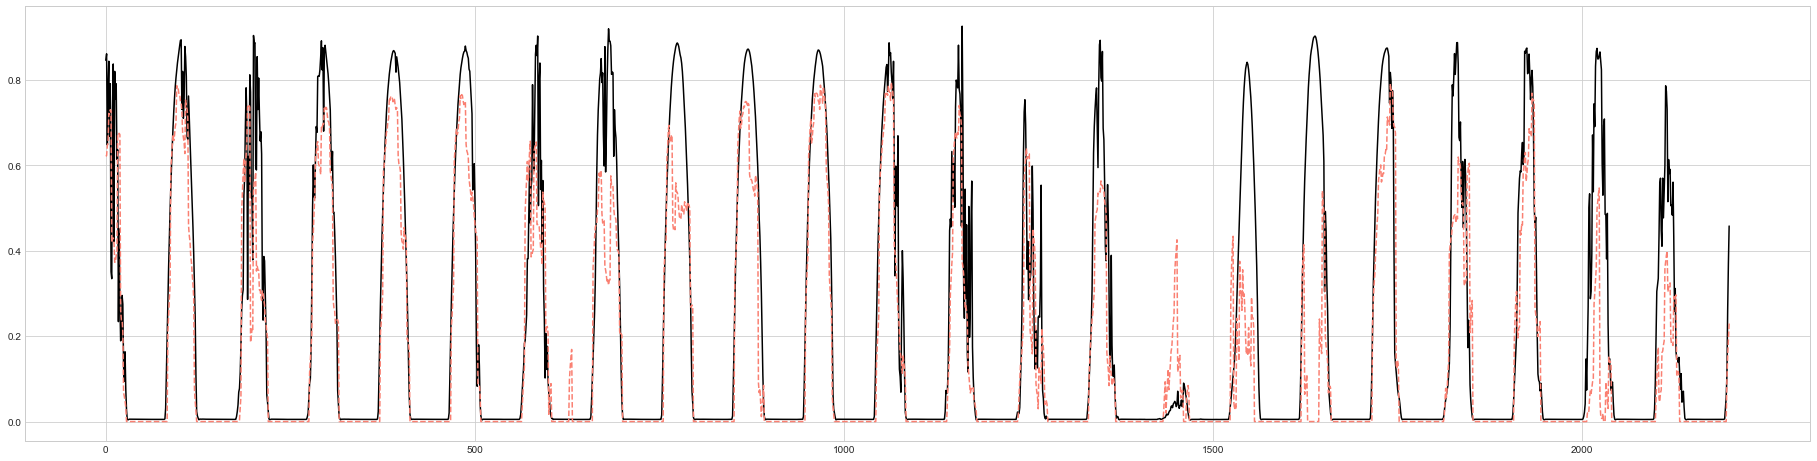

In [52]:
cut = 2_200

fig, ax = plt.subplots(1,1, figsize=(32, 8))

ax.plot(truelist[-cut:], color='black')
ax.plot(predlist[-cut:], color='salmon', linestyle='dashed')

plt.show()

## The End